In [3]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
movies = pd.read_csv(r"C:\Users\LOQ\OneDrive\Datasets\tmdb_5000_movies.csv", encoding='unicode_escape')
credits = pd.read_csv(r"C:\Users\LOQ\OneDrive\Datasets\tmdb_5000_credits.csv", encoding='unicode_escape')
movies = movies.merge(credits, on='title')
movies = movies[['movie_id', 'title', 'overview', 'keywords', 'cast', 'crew', 'vote_average', 'genres']]
movies.isnull().sum()
movies.dropna(inplace=True)

In [5]:
def extract_names(json_column):
    extracted = []
    for value in json_column:
        try:
            data = ast.literal_eval(value)
            extracted.append(' '.join([person['name'] for person in data if 'name' in person]))
        except:
            extracted.append('')
    return pd.Series(extracted)

In [6]:
movies['keywords'] = extract_names(movies['keywords'])
movies['cast'] = extract_names(movies['cast'])
movies['crew'] = extract_names(movies['crew'])
movies['genres'] = extract_names(movies['genres'])  # Extract genre names
movies['combined_text'] = (movies['title'] + ' ' + movies['overview'] + ' ' + 
                          movies['keywords'] + ' ' + movies['cast'] + ' ' + 
                          movies['crew'] + ' ' + movies['genres'])
movies['combined_text'] = movies['combined_text'].astype(str).fillna('')

In [7]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(movies['combined_text']).toarray()

In [8]:
movies['recommendation'] = movies['vote_average'].apply(lambda x: 1 if x > 7 else 0)  # Binary classification
y = movies['recommendation']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8, test_size=0.2, random_state=42)

In [10]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn) * 100
print(f"KNN Accuracy: {acc_knn:.2f}%")

KNN Accuracy: 81.89%


In [11]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=10, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
acc_dt = accuracy_score(y_test, y_pred_dt) * 100
print(f"Decision Tree Accuracy: {acc_dt:.2f}%")

Decision Tree Accuracy: 80.85%


In [12]:
rf = RandomForestClassifier(n_estimators=100, max_depth=15, min_samples_split=5, 
                            random_state=42, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf) * 100
print(f"Random Forest Accuracy: {acc_rf:.2f}%")

Random Forest Accuracy: 81.37%


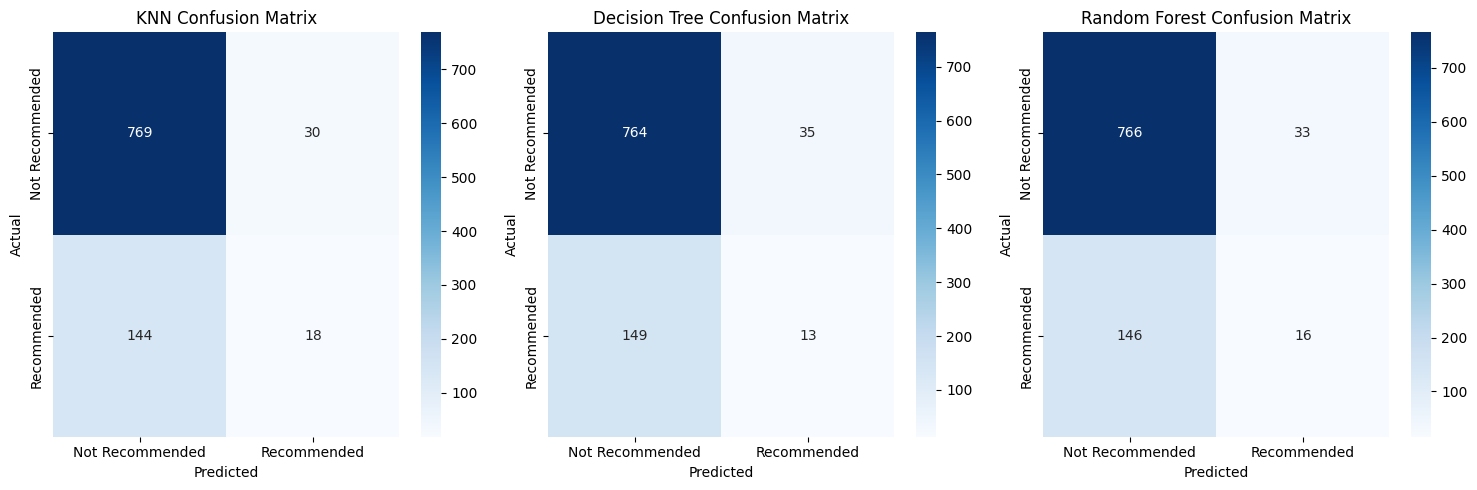

In [13]:
label_names = ['Not Recommended', 'Recommended']

def plot_confusion_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_confusion_matrix(y_test, y_pred_knn, 'KNN Confusion Matrix', axes[0])
plot_confusion_matrix(y_test, y_pred_dt, 'Decision Tree Confusion Matrix', axes[1])
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest Confusion Matrix', axes[2])
plt.tight_layout()
plt.show()

C:\Users\LOQ\AppData\Local\Temp\ipykernel_3952\2424026775.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


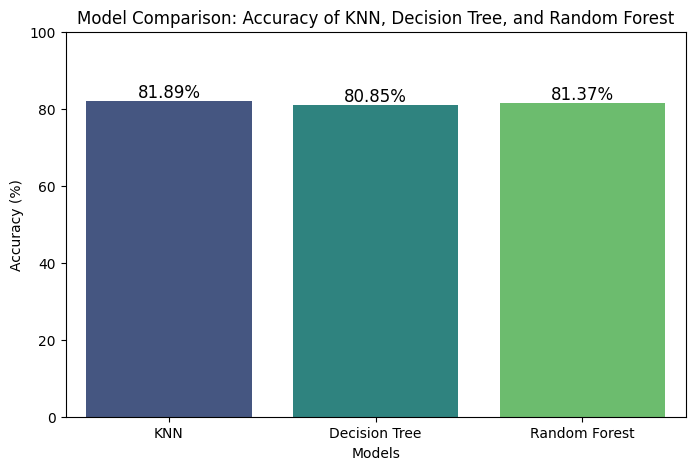

In [14]:
models = ['KNN', 'Decision Tree', 'Random Forest']
accuracies = [acc_knn, acc_dt, acc_rf]

plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Model Comparison: Accuracy of KNN, Decision Tree, and Random Forest')
plt.ylim(0, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)
plt.show()